In [3]:
import pandas as pd
import re

In [4]:
unprocessed = pd.read_csv("../data/curated/input.csv")

In [5]:
unprocessed

,URL,Rent_Price,Bedrooms,Bathrooms,Parking,Property_Type,Street,Suburb,Postcode,Distance_to_Nearest_Station_km,Cleaned_Text,Sentiment,Cleaned_HLTokens,Dominant_Topic,Dominant_Topic_Label,negative_class,positive_class,geometr_2km,School_Counts
0,https://www.domain.com.au/14-70-canterbury-roa...,790.0,1,1,−,Apartment / Unit / Flat,14/70 Canterbury Road,Toorak,3142,1.009717,phone enquiry d renovated victorian style unit...,0.209004,"['toorak', 'apartment', 'yard', 'unlimited', '...",1,"Beautiful, Convenient Family Homes",0.0,1.0,POLYGON ((16144528.593636421 -4557194.45220456...,9.0
1,https://www.domain.com.au/421-422-collins-stre...,475.0,1,1,−,Apartment / Unit / Flat,421/422 Collins Street,Melbourne,3000,0.777577,golden opportunity sure delight seeking fabulo...,0.271238,"['light', 'bright', 'unbeatable', 'location']",2,"Modern, Low-Maintenance Apartments",0.0,1.0,POLYGON ((16138889.938601218 -4553619.89105021...,9.0
2,https://www.domain.com.au/8-1068-lygon-street-...,730.0,3,2,2,Apartment / Unit / Flat,8/1068 Lygon Street,Carlton North,3054,1.560109,superb bedroom spacious apartment excellent na...,0.274026,"['spacious', 'bedroom', 'apartment', 'bathroom...",2,"Modern, Low-Maintenance Apartments",0.0,1.0,POLYGON ((16140046.06943675 -4548526.273504933...,11.0
3,https://www.domain.com.au/16-19-mercer-road-ar...,625.0,2,1,1,Apartment / Unit / Flat,16/19 Mercer Road,Armadale,3143,0.821527,spacious secure bedroom apartment need superb ...,0.265833,"['leafy', 'surrounds', 'central', 'lifestyle',...",0,Family Homes in Prime Locations,0.0,1.0,POLYGON ((16146240.83212016 -4558863.517405337...,8.0
4,https://www.domain.com.au/17-17-macquarie-stre...,330.0,1,1,−,Apartment / Unit / Flat,17/17 Macquarie Street,Prahran,3181,0.296351,open inspection refer unit c situated heart pr...,0.147273,"['stylish', 'student', 'accommodation', 'prahr...",3,Stunning Furnished Apartments/Townhouses,0.0,1.0,POLYGON ((16142457.594697755 -4558331.39042049...,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,https://www.domain.com.au/10-mackinnon-court-k...,650.0,4,2,2,House,10 MacKinnon Court,Keysborough,3173,3.178492,barry plant award winning property management ...,0.252381,"['bedroom', 'bathroom', 'home']",4,Central Units for Lease,0.0,1.0,POLYGON ((16161367.904140668 -4577466.66054323...,3.0
10014,https://www.domain.com.au/10-109-manningham-st...,690.0,2,2,1,Apartment / Unit / Flat,10 109 Manningham St,Parkville,3052,0.551130,uko royal park discover premium living uko roy...,0.333571,"['park', 'living', 'speed', 'wi', 'fi', 'frien...",4,Central Units for Lease,0.0,1.0,"POLYGON ((16136731.63178592 -4549012.76962011,...",13.0
10015,https://www.domain.com.au/2-owl-road-doreen-vi...,480.0,3,2,1,House,2 Owl Road,Doreen,3754,4.182653,modern living house located new estate laurima...,0.211616,"['turn', 'key']",3,Stunning Furnished Apartments/Townhouses,0.0,1.0,POLYGON ((16157535.752934009 -4520494.43934586...,1.0
10016,https://www.domain.com.au/89-axford-boulevard-...,620.0,4,2,2,House,89 AXFORD BOULEVARD,Wodonga,3690,281.971197,situated heart highly sought white box rise es...,0.110583,"['stunning', 'family', 'home']",4,Central Units for Lease,0.0,1.0,POLYGON ((16354918.646373019 -4320462.42301470...,1.0


In [7]:
pattern = pattern = r'(?:\d+[A-Za-z]?\/?)?\d+[A-Za-z]?\s+([A-Za-z\s\'\-]+)'
unprocessed['Street_Name'] = unprocessed['Street'].str.extract(pattern)
unprocessed = unprocessed[['Rent_Price', 'Bedrooms', 'Bathrooms', 'Parking', 'Property_Type',
        'Suburb', 'Postcode', 'Distance_to_Nearest_Station_km',
        'Cleaned_Text', 'Sentiment', 'Cleaned_HLTokens',
       'Dominant_Topic', 'Dominant_Topic_Label', 'negative_class',
       'positive_class', 'Street_Name', 'School_Counts']]

In [8]:
unprocessed.columns

Index(['Rent_Price', 'Bedrooms', 'Bathrooms', 'Parking', 'Property_Type',
       'Suburb', 'Postcode', 'Distance_to_Nearest_Station_km', 'Cleaned_Text',
       'Sentiment', 'Cleaned_HLTokens', 'Dominant_Topic',
       'Dominant_Topic_Label', 'negative_class', 'positive_class',
       'Street_Name', 'School_Counts'],
      dtype='object')

- Nominal: 'Property_Type', 'Suburb', 'Postcode', 'Dominant_Topic'(HL), 'Street_Name'
- Numerical continuous: 'Sentiment'(PD), 
- Numerical discrete: 'Bedrooms', 'Bathrooms', 'Parking', 'CountOfSchool', 'negative_class'(PD), 'positive_class'(PD), 'School_counts'
- TextData: 'Cleaned_text' -> property description, 'Cleaned_HLTokens'-> Headline

## Encoding

In [10]:
processed = unprocessed.copy()
numerical = ['Bedrooms', 'Bathrooms', 'Parking', 'negative_class', 'positive_class','Sentiment', 'Rent_Price', 'School_Counts']
nominal = ['Property_Type', 'Suburb', 'Postcode', 'Dominant_Topic', 'Street_Name']
text = ['Cleaned_text', 'Cleaned_HLTokens']
processed = unprocessed[numerical]

In [11]:
from sklearn.feature_extraction import FeatureHasher

# One hot encoding 
one_hot_property_type = pd.get_dummies(unprocessed['Property_Type'], prefix='Property_Type').astype(int)
processed = pd.concat([processed, one_hot_property_type], axis=1)

# Target encoding
mean_target_per_suburb = unprocessed.groupby('Suburb')['Rent_Price'].mean()
unprocessed['Suburb_encoded'] = unprocessed['Suburb'].map(mean_target_per_suburb)
processed['Suburb_encoded'] = unprocessed['Suburb_encoded']

# One hot encoding 
one_hot_dominant_topic = pd.get_dummies(unprocessed['Dominant_Topic'], prefix='Dominant_Topic').astype(int)
processed = pd.concat([processed, one_hot_dominant_topic], axis=1)

# Hash encoding
unprocessed['Street_Name'] = unprocessed['Street_Name'].apply(lambda x: [str(x)])
hasher = FeatureHasher(input_type='string', n_features=10)
hashed_street_name = hasher.transform(unprocessed['Street_Name'])
hashed_street_df = pd.DataFrame(hashed_street_name.toarray(), columns=[f"hash_{i}" for i in range(10)])

processed = pd.concat([processed, hashed_street_df], axis=1)


/var/folders/ly/fm0kkb6x1b91l8mnvhcy7kg00000gn/T/ipykernel_15373/88293862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unprocessed['Suburb_encoded'] = unprocessed['Suburb'].map(mean_target_per_suburb)
/var/folders/ly/fm0kkb6x1b91l8mnvhcy7kg00000gn/T/ipykernel_15373/88293862.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unprocessed['Street_Name'] = unprocessed['Street_Name'].apply(lambda x: [str(x)])


In [12]:
processed

,Bedrooms,Bathrooms,Parking,negative_class,positive_class,Sentiment,Rent_Price,School_Counts,Property_Type_Acreage / Semi-Rural,Property_Type_Apartment / Unit / Flat,...,hash_0,hash_1,hash_2,hash_3,hash_4,hash_5,hash_6,hash_7,hash_8,hash_9
0,1,1,−,0.0,1.0,0.209004,790.0,9.0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,1,−,0.0,1.0,0.271238,475.0,9.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,2,2,0.0,1.0,0.274026,730.0,11.0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,1,1,0.0,1.0,0.265833,625.0,8.0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,−,0.0,1.0,0.147273,330.0,14.0,0,1,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,4,2,2,0.0,1.0,0.252381,650.0,3.0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10014,2,2,1,0.0,1.0,0.333571,690.0,13.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
10015,3,2,1,0.0,1.0,0.211616,480.0,1.0,0,0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10016,4,2,2,0.0,1.0,0.110583,620.0,1.0,0,0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
processed['Parking'] = processed['Parking'].replace('−', '0')
processed['Parking'] = pd.to_numeric(processed['Parking'])


In [32]:
processed.to_csv("../data/curated/engineered.csv", index = False)

In [14]:
X = processed.drop("Rent_Price", axis = 1)
y = processed['Rent_Price']

In [100]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(max_features=100) 

# headline_tfidf = tfidf.fit_transform(unprocessed['Cleaned_HLTokens'])

# tfidf_df = pd.DataFrame(headline_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# X = pd.concat([X, tfidf_df], axis=1)


### Feature selecting using Mutual information

In [23]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_regression, SelectKBest
mi = mutual_info_regression(X, y)

k = 20
selector = SelectKBest(score_func=mutual_info_regression, k=k)
X_selected = selector.fit_transform(X, y)

selected_features = selector.get_support(indices=True)
print(f"Mutual Information scores: {mi}")
print(f"Selected feature indices: {selected_features}")

Mutual Information scores: [1.68362956e-01 1.42266383e-01 7.68341915e-02 2.00427851e-03
 1.13069039e-02 6.90632286e-02 4.05972927e-02 0.00000000e+00
 2.15100023e-02 0.00000000e+00 5.47167610e-04 2.66943275e-02
 2.04707344e-03 1.41762798e-03 1.12154110e-02 3.38044913e-02
 0.00000000e+00 1.95980136e-02 3.40467799e-03 3.15280634e-01
 9.13843855e-05 0.00000000e+00 6.73649289e-03 1.55296107e-02
 1.39302282e-02 9.94731376e-03 0.00000000e+00 3.42398718e-04
 1.00360402e-02 1.47684790e-02 0.00000000e+00 1.36323440e-02
 0.00000000e+00 0.00000000e+00 1.27887818e-02]
Selected feature indices: [ 0  1  2  3  4  5  6  7  8  9 11 15 16 17 18 19 27 28 33 34]


                Bedrooms  Bathrooms   Parking  negative_class  positive_class  \
Bedrooms        1.000000   0.562090  0.489017       -0.052205        0.053341   
Bathrooms       0.562090   1.000000  0.334284       -0.022070        0.024386   
Parking         0.489017   0.334284  1.000000       -0.012193        0.013792   
negative_class -0.052205  -0.022070 -0.012193        1.000000       -0.979296   
positive_class  0.053341   0.024386  0.013792       -0.979296        1.000000   
Sentiment       0.107991   0.097686  0.057714       -0.167617        0.169470   
School_Counts  -0.453044  -0.296146 -0.324501        0.024289       -0.025425   
Rent_Price      0.397174   0.442724  0.190045       -0.070572        0.073365   

                Sentiment  School_Counts  Rent_Price  
Bedrooms         0.107991      -0.453044    0.397174  
Bathrooms        0.097686      -0.296146    0.442724  
Parking          0.057714      -0.324501    0.190045  
negative_class  -0.167617       0.024289   -0.0705

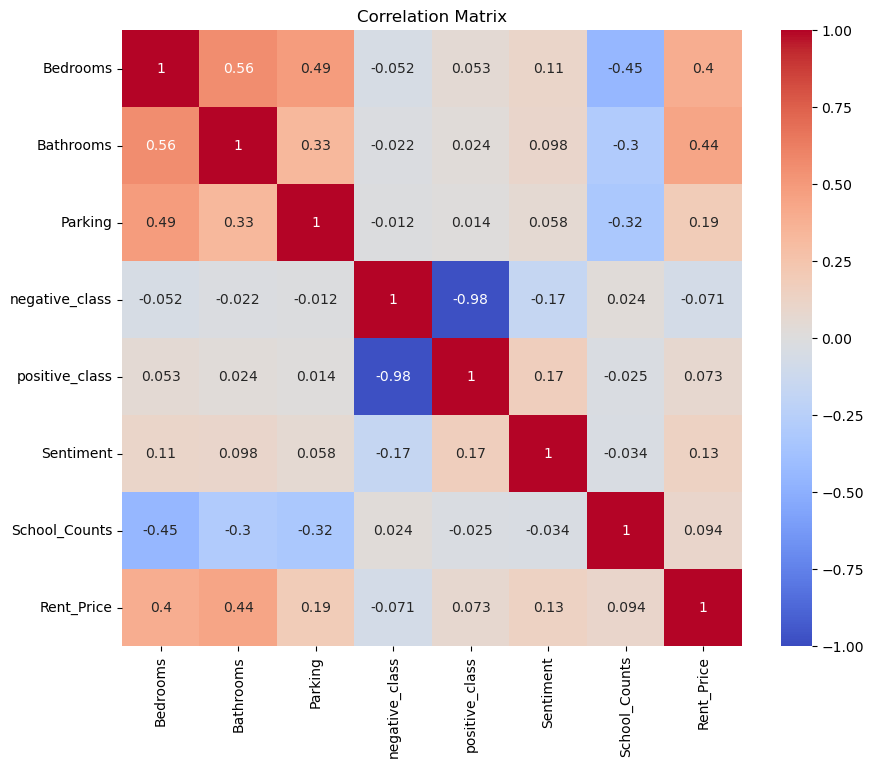

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
## Seeing correlations between numerical and rent
correlation_matrix = processed[['Bedrooms', 'Bathrooms', 'Parking','negative_class', 'positive_class','Sentiment','School_Counts', 'Rent_Price']].corr()

print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


### Preliminary Regression model

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

print(f"Selected feature indices: {selected_features}")


Mean Squared Error (MSE): 10791.538348094378
R-squared (R²): 0.5771780662591153
Selected feature indices: [ 0  1  2  3  4  5  6  7  8  9 11 15 16 17 18 19 27 28 33 34]


In [27]:
from sklearn.ensemble import RandomForestRegressor

rfmodel =RandomForestRegressor()
rfmodel.fit(X_train, y_train)

y_pred = rfmodel.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

print(f"Selected feature indices: {selected_features}")


Mean Squared Error (MSE): 8216.198262868642
R-squared (R²): 0.678082148675488
Selected feature indices: [ 0  1  2  3  4  5  6  7  8  9 11 15 16 17 18 19 27 28 33 34]


In [30]:
from sklearn.ensemble import GradientBoostingRegressor
gbmodel =GradientBoostingRegressor()
gbmodel.fit(X_train, y_train)

y_pred = gbmodel.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
print(f"Selected feature indices: {selected_features}")

Mean Squared Error (MSE): 8853.487327759505
R-squared (R²): 0.6531126043827915
Selected feature indices: [ 0  1  2  3  4  5  6  7  8  9 11 15 16 17 18 19 27 28 33 34]


In [31]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet()

elastic_net.fit(X_train, y_train)

y_pred = elastic_net.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(11367.218919796771, 0.5546223967435411)

### Random forest hyperparameter tuning

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  
    cv=3,       
    verbose=2,
    random_state=42,
    n_jobs=-1  
)

random_search.fit(X.fillna(0), y)

best_params = random_search.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas require

[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=

/Users/tinas/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  26.4s


/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  25.5s


/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.8s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  32.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  12.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  12.8s


/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  33.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.8s


/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  13.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  33.1s


/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  13.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  10.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  12.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  10.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  12.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  10.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf

/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  25.8s


/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  20.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  20.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  20.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  16.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  10.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  16.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  32.0s
[CV] END bootstrap=True, max_depth=None, min

/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/tinas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   4.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  31.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, min_sam

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': True}

In [36]:
rf_model = RandomForestRegressor(n_estimators= 1000,
 min_samples_split= 2,
 min_samples_leaf = 1,
 max_depth= None,
 bootstrap = True)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [38]:
mse
r2

0.6836842338544022